# BYOM with Tensorflow: Sound Based Predictive Maintenance

In [ ]:
from ai_api_client_sdk.ai_api_v2_client import AIAPIV2Client
import json

In [ ]:
# Your service key JSON file relative to this notebook
aic_service_key_path = '../files/aic_service_key.json'

# Loads the service key file
with open(aic_service_key_path) as ask:
    aic_service_key = json.load(ask)

# Creating an AI API client instance
ai_api_client = AIAPIV2Client(
    base_url = aic_service_key["serviceurls"]["AI_API_URL"] + "/v2", # The present AI API version is 2
    auth_url=  aic_service_key["url"] + "/oauth/token",
    client_id = aic_service_key['clientid'],
    client_secret = aic_service_key['clientsecret']
)

### Already done in defect detection exercise

# Create and upload the docker images

Start docker on your machine and execute the following commands in a terminal:

- docker login docker.io -u YOUR_DOCKER_REPO

- docker build code/train -t YOUR_DOCKER_REPO/sound-train:0.0.1 .

- docker push docker.io/YOUR_DOCKER_REPO/sound-train:0.0.1

NB: you should be connected to SAP VPN to download sap-ai-tracking module.

In order to make the API call, let's transform the array into a binary string:

# Create Resource Group and Connect AWS S3 to SAP AI Core

Resource Groups represent a virtual collection of related resources within the scope of one SAP AI Core tenant. Previously we have created a specific resource group for our condition monitoring exercise to keep separated those resources.
That resource group will appear also on the AI Lauchpad UI. By selecting it, all the related resource will be accessibles.
Let's see how to add resources to the "sound" resource group.

AI Core uses AWS S3 Object Store as a cloud storage for your datasets and models. 
You can get AWS S3 Bucket from either of two ways:

- through SAP BTP Cockpit;

- through AWS. Refer AWS User Guide to S3.

A prerequisite to our exercise is to install AWS CLI and upload our dataset to AWS S3 Object Store by means of a command like the following:

    aws s3 cp --recursive /local/path/to/data s3://your-bucket-id/sound/data/

Once we have done this, we need to register the AWS S3 Object Store to SAP AI Core resource group. In order to to that we prepare a json file with the needed AWS S3 credentials and we use a proper API in order to register it:

In [ ]:
# Loads your service key
s3_service_key_path = '../files/s3_service_key.json'

# Loads the service key file
with open(s3_service_key_path) as s3sk:
    s3_service_key = json.load(s3sk)

default_secret = {
    "name": "default", # Name of the connection
    "type": "S3",
    "endpoint": s3_service_key["host"],
    "bucket": s3_service_key["bucket"],
    "pathPrefix": "sound",
    "region": s3_service_key["region"],
    "data": {
        "AWS_ACCESS_KEY_ID": s3_service_key["access_key_id"],
        "AWS_SECRET_ACCESS_KEY": s3_service_key["secret_access_key"]
    }
}

# Call the api
ai_api_client.rest_client.post(
    path="/admin/objectStoreSecrets",
    body = default_secret, # defined above
    resource_group = "sound" #This specifies the resource group the AWS S3 bucket is related to
)

Let's make an API call to check if the artifact was corretly created. Object store secrets are stored under /admin/objectStoreSecrets and are linked to the resource group "sound", so those parameters have to be provided when creating and listing them. In case, with a similar call, secrets can be also deleted.

In [ ]:
ai_api_client.rest_client.get(
    path="/admin/objectStoreSecrets",
    resource_group = "sound"
)

It is always a good practice to check the synchronization of the workflows (registered as apps), that are read from the registered GitHub repository. 
Please, keep in mind that the synchronization is triggered by any change to the yaml files pushed to GitHub and that AI Core checks every 3 minutes for new files or changes.

In [ ]:
app_name = "aicore-sound"

ai_api_client.rest_client.get(
    path=f"/admin/applications/{app_name}/status"
)

# Train Execution of ML Model

In [2]:
import sys, os
import json
import requests
import base64
import time
import yaml
from IPython.display import clear_output
from pprint import pprint

from ai_api_client_sdk.ai_api_v2_client import AIAPIV2Client
from ai_api_client_sdk.models.artifact import Artifact
from ai_api_client_sdk.models.status import Status
from ai_api_client_sdk.models.target_status import TargetStatus
from ai_api_client_sdk.models.parameter_binding import ParameterBinding
from ai_api_client_sdk.models.input_artifact_binding import InputArtifactBinding

In order to be able to train our model in AI Core, we need to define an AI API client, this time by specifying also the resource group in order to access all the related resource (i.e. artifacts and scenarios) and store the subsequent objects (like configurations, models, etc...)

In [7]:
resource_group = "sound-u0001" # Must be created before

aic_service_key = '../exercises/files_set/aic_service_key.json' # ENSURE YOU HAVE THE FILE PLACED CORRECTLY
with open(aic_service_key) as ask:
    aic_s_k = json.load(ask)

# NO CHANGES REQUIRED BELOW
#
ai_api_v2_client = AIAPIV2Client(
    base_url=aic_s_k["serviceurls"]["AI_API_URL"] + "/v2/lm",
    auth_url=aic_s_k["url"] + "/oauth/token",
    client_id=aic_s_k['clientid'],
    client_secret=aic_s_k['clientsecret'],
    resource_group=resource_group)

Previously we have defined some scenarios (through the provided workflow yaml files) for our resource group. We can check if they are present:

In [ ]:
scenario_resp = ai_api_v2_client.scenario.query(resource_group)

print("Scenarios")
print("---" * 20)
for idx, scenario in enumerate(scenario_resp.resources):
    print(f"Scenario ID {idx + 1} -> [{scenario.id}]")

In order to be used, training data need to be registered as artifact in AI Core. This means specify some data parameters and associate them to an existing scenario. Below an example on how to perform this registration in the context of our exercise.


Please, note that ai://default/data is the path to the data in S3 and "default" is specified in the secret object store registration. If you have specified also a pathPrefix, that will be already include in "default".


The scenario id is assigned as the one specified into the training workflows (we read it from the local file, and it should match the one read by AICore from the GitHub repository). At the end of the registrazioni step, a unique id is assigned to the artifact. Once registered the artifact will appear in the "Dataset" section in AI Launchpad.

NB: This step needs to be executed only when registering a new dataset, or something has changed in the current dataset.

In [ ]:
# NO CHANGES REQUIRED BELOW
#
# Load training_workflow.yaml
training_workflow_file = '../workflows_sound/training_workflow.yaml'
with open(training_workflow_file) as twf:
    training_workflow = yaml.safe_load(twf)
#
# Load scenario id from train_workflow.yaml
scenario_id = training_workflow['metadata']['labels']['scenarios.ai.sap.com/id']
#
# Set the artifact configuration
artifact = {
        "name": "sound-data", # Modifiable name
        "kind": Artifact.Kind.DATASET,
        "url": "ai://default/data", #default is 
        "description": "Cutting machine sound clips for defect detection",
        "scenario_id": scenario_id
    }
# Store the artifact response to retrieve the id for the training configuration
artifact_resp = ai_api_v2_client.artifact.create(**artifact)
print(f"Artifacts registered for {scenario_id} scenario!")
pprint(vars(artifact_resp))
#
# Checks if the message contains expected string
assert artifact_resp.message == 'Artifact acknowledged'

In order to train our model, we need to create a training configuration in AICore. A configuration convey several information about the training:

- the name of the configuration itself;
- the name that will indetify the input data inside AICore (it is assigned in the workflow);
- the name that will identify the training executable in AICore (it is assigned in the workflow);
- the id of the related scenario

At the end of the configuration step, a unique id is assigned to the configuration. Once created the configuration will appear in the "Configuration" section in AI Launchpad.

NB: Also in this case, the configuration is created one time, unless something has changed or you need to execute another training on a different dataset.

In [ ]:
input_artifact_name = training_workflow['spec']['templates'][0]['inputs']['artifacts'][0]['name']
executable_name = training_workflow['metadata']['name']

artifact_binding = {
    "key": input_artifact_name,
    "artifact_id": artifact_resp.id
}

train_configuration = {
    "name": "sound-training-configuration",
    "scenario_id": scenario_id,
    "executable_id": executable_name,
    "parameter_bindings": [],
    "input_artifact_bindings": [ InputArtifactBinding(**artifact_binding) ]
}

# store the configuration response to access the id to create an execution
train_config_resp = ai_api_v2_client.configuration.create(**train_configuration)
pprint(vars(train_config_resp))

assert train_config_resp.message == 'Configuration created'

print("Configuration created for running the training")

Once the configuration is created, we are ready to creare an execution that will be immediatly launched:

In [ ]:
execution_resp = ai_api_v2_client.execution.create(train_config_resp.id)
pprint(vars(execution_resp))

The following code provide information about the training status. The training status can be also checked in AI Launchpad under the "Execution" sections.

Please, note that the execution is performed inside the docker image previosly prepared and loaded in the Docker repository. The information needed to access the Docker training image are specified inside the training workflow file loaded in GitHub which AICore is synchronized with.

Once the training is complete, a model is saved and it becomes available under the AI Launchpad "Models" section for deploying a serving artifact.

In [ ]:
status = None
while status != Status.COMPLETED and status != Status.DEAD:
    # Sleep for 5 secs to avoid overwhelming the API with requests
    time.sleep(5)
    # Clear outputs to reduce clutter
    clear_output(wait=True)

    execution = ai_api_v2_client.execution.get(execution_resp.id)
    status = execution.status
    print('...... execution status ......', flush=True)
    print(f"Training status: {execution.status}")
    print(f"Training status details: {execution.status_details}")


if execution.status == Status.COMPLETED:
    print(f"Training complete for execution [{execution_resp.id}]!")
    output_artifact = execution.output_artifacts[0]
    output = {
        "id": output_artifact.id,
        "name": output_artifact.name,
        "url": output_artifact.url
    }
    with open('training_output.json', 'w') as fp:
        json.dump(output, fp)

# Metrics and performance

A common need is to check the performance of the training. To that it is possible to define some metrics in the training code and register them inside AiCore. This will made them available once the training is complete.

Below some example about how to retrieve the metrics from AICore.

In [9]:
import ast
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [8]:
exec_id = execution_resp.id
#exec_id = 'e8b5c738b97af37b'
metric_resp = ai_api_v2_client.metrics.query(execution_ids=exec_id)

for m in metric_resp.resources:
    for metric in m.metrics:
        print(metric.name)
        print(metric.value)

Model Accuracy
0.9900990128517151


In [10]:
all_metrics = []
for m in metric_resp.resources:
    for custom_info in m.custom_info:
        #print(custom_info.name)
        #print(custom_info.value)
        all_metrics.append(custom_info.value)

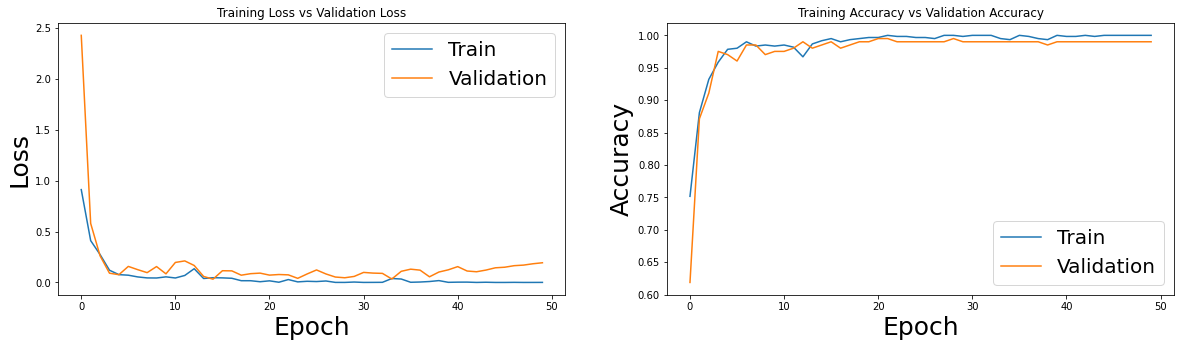

In [12]:
training_metrics = ast.literal_eval(all_metrics[0])
fig, axs = plt.subplots(1, 2, figsize=(20,5))

a = ast.literal_eval(training_metrics[0].get("loss"))
b = ast.literal_eval(training_metrics[1].get("val_loss"))
c = ast.literal_eval(training_metrics[2].get("accuracy"))
d = ast.literal_eval(training_metrics[3].get("val_accuracy"))

axs[0].plot(a)
axs[0].plot(b)
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Validation'], prop={'size': 20})

axs[1].plot(c)
axs[1].plot(d)
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Validation'], prop={'size': 20})

e=axs[0].set_xlabel('Epoch',fontsize=25)
e=axs[0].set_ylabel('Loss',fontsize=25)
e=axs[1].set_xlabel('Epoch',fontsize=25)
e=axs[1].set_ylabel('Accuracy',fontsize=25)

In [11]:
training_metrics = ast.literal_eval(all_metrics[0])
confusion_matrix = ast.literal_eval(all_metrics[1])
print(confusion_matrix['classes'])
print(confusion_matrix['cf_matrix'])

classes = confusion_matrix['classes']
cnf_matrix = confusion_matrix['cf_matrix']
cnf_matrix = np.array(cnf_matrix)
print(cnf_matrix)

['anomaly2', 'ok', 'anomaly1']
[[48, 0, 0], [0, 103, 0], [2, 0, 49]]
[[ 48   0   0]
 [  0 103   0]
 [  2   0  49]]


In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


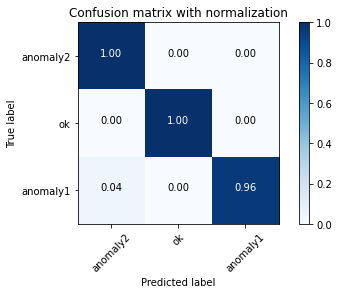

In [14]:
import itertools

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                      title='Confusion matrix with normalization')

# Deploy ML Model

The model deployment is aimed at the creation and the deployment of a serving API (or artifact) that can be called to perform the inference step on some data.

To do that, first one needs to provide a piece of code where it is specified the behaviour of the artifact and a proper environment where the serving artifact can run. Assuming the code has been developed, one has to create a proper Docker image for running the application.

In order to prepare the docker image with the proper content, a Docker file and a requirement.txt file have to be prepared. Then the image needs to be built and uploaded with the following commands.

- docker build -t YOUR_DOCKER_REPO/sound-serve:0.0.1 .
- docker push docker.io/YOUR_DOCKER_REPO/sound-serve:0.0.1

In [ ]:
serving_workflow_file = '../workflows_sound/serving_workflow_tutorial.yaml'
with open(serving_workflow_file) as swf:
    serving_workflow = yaml.safe_load(swf)

scenario_id = serving_workflow['metadata']['labels']['scenarios.ai.sap.com/id']
input_artifact_name = serving_workflow['spec']['inputs']['artifacts'][0]['name']
executable_name = serving_workflow['metadata']['name']

training_output = 'training_output.json'
with open(training_output) as to:
    serving_input = json.load(to)

In [ ]:
artifact_binding = {
    "key": input_artifact_name,
    "artifact_id": serving_input["id"]
}

serve_configuration = {
    "name": "serving-configuration",
    "scenario_id": scenario_id,
    "executable_id": executable_name,
    "parameter_bindings": [],
    "input_artifact_bindings": [ InputArtifactBinding(**artifact_binding) ]
}

serve_config_resp = ai_api_v2_client.configuration.create(**serve_configuration)

assert serve_config_resp.message == 'Configuration created'

pprint(vars(serve_config_resp))
print("configuration for serving the model created")

In [ ]:
deployment_resp = ai_api_v2_client.deployment.create(serve_config_resp.id)
pprint(vars(deployment_resp))

In [ ]:
# Poll deployment status
status = None
while status != Status.RUNNING and status != Status.DEAD:
    time.sleep(5)
    clear_output(wait=True)
    deployment = ai_api_v2_client.deployment.get(deployment_resp.id)
    status = deployment.status
    print('...... deployment status ......', flush=True)
    print(deployment.status)
    pprint(deployment.status_details)

    if deployment.status == Status.RUNNING:
        print(f"Deployment with {deployment_resp.id} complete!")

# Allow some time for deployment URL to get ready
time.sleep(10)

# Using deployed ML model

Let's define the local path to the dataset:

In [ ]:
import glob

path_normal_sounds = glob.glob("../data/normal/*")
path_abnormal_sounds = glob.glob("../data/abnormal/*")
#print(path_normal_sounds)
#print(path_abnormal_sounds)

Let's visualize some audio clips:

In [ ]:
import librosa
import librosa.display

def acoustic_feature_computation(clip,sr):
    #scale, sr = librosa.load(clip)
    scale=clip
    mel_spectrogram = librosa.feature.melspectrogram(
        y=scale, 
        sr=sr, 
        hop_length=512,
        n_mels=64,
        fmax=sr/2
    )
    log_mel = librosa.power_to_db(mel_spectrogram)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    MFCCs=librosa.feature.mfcc(y=scale, sr=sr, n_mfcc=40, fmax=sr/2)
    acoustic_features=np.concatenate((MFCCs,log_mel_spectrogram), axis=0)
    return acoustic_features

In [ ]:
scale_abn, sr_abn = librosa.load(path_abnormal_sounds[0])
scale_norm, sr_norm = librosa.load(path_normal_sounds[0])
#print(scale_abn, scale_norm)

First let's visualize the two examples:

In [ ]:
acoustic_features_abn = acoustic_feature_computation(scale_abn,sr_abn)
acoustic_features_norm = acoustic_feature_computation(scale_norm,sr_norm)
print(acoustic_features_abn.shape)
print(acoustic_features_norm.shape)

Abnormal sound clip:

In [ ]:
plt.pcolor(acoustic_features_abn)
plt.show()

Normal sound clip:

In [ ]:
plt.pcolor(acoustic_features_norm)
plt.show()

In order to perform the inference step, let's transform one of the sound clips into a string (this will constitute  the body of the API call):

In [ ]:
from base64 import b64encode
import base64
import io
from json import dumps

ENCODING = 'utf-8'

# first: reading the binary stuff
# note the 'rb' flag
# result: bytes
with open(path_abnormal_sounds[0], 'rb') as open_file:
    byte_content = open_file.read()

# second: base64 encode read data
# result: bytes (again)
base64_bytes = b64encode(byte_content)

# third: decode these bytes to text
# result: string (in utf-8)
base64_string = base64_bytes.decode(ENCODING)

# optional: doing stuff with the data
# result here: some dict
raw_data = {"sound": base64_string}

In [ ]:
f = open("sounds.txt", "w")
f.write(base64_string)
f.close()
#print(base64_string)

Let's make a call to the API for retrieving the prediction:

In [ ]:
endpoint = f"{deployment.deployment_url}/v1/models/soundmodel:predict"
print(endpoint)

headers = {"Authorization": ai_api_v2_client.rest_client.get_token(),
           'ai-resource-group': resource_group,
           "Content-Type": "application/json"}
response = requests.post(endpoint, headers=headers, json=raw_data)

print('Inference result:', response.json())
#pprint(vars(response))

# Stop deployed model

In [ ]:
delete_resp = ai_api_v2_client.deployment.modify(deployment_resp.id,
                                                 target_status=TargetStatus.STOPPED)
status = None
while status != Status.STOPPED:
    time.sleep(5)
    clear_output(wait=True)
    deployment = ai_api_v2_client.deployment.get(deployment_resp.id)
    status = deployment.status
    print('...... killing deployment ......', flush=True)
    print(f"Deployment status: {deployment.status}")